In [48]:
from pathlib import Path
from tqdm.auto import tqdm

import math
import numpy as np

from sklearn import preprocessing
import umap

import matplotlib.pyplot as plt
import seaborn as sns

import MDAnalysis as mda
from MDAnalysis.analysis.align import rotation_matrix
from MDAnalysis.analysis.rms import rmsd
import pandas as pd


In [115]:
# Peptides and simulation details

title="WF1a_WF2"
peptide = "WF2"
ref_pep = 1 # reference peptide

#if you want to chop the peptide
start_chop, end_chop = 0, 0

# if you want to use carbon alpha atoms only
c_alpha = True
step_size = 50

p = f"/Volumes/miru_backup/jade_2synergy/popg/WF1a_WF2_pg"
structure = f"{p}/md_0_1.tpr"
trajectory = f"{p}/md_0_1_combined.xtc"

output_dir =f"/Users/mirunaserian/Documents/WF_synergy/umap/WF2_step{step_size}_positions"
Path(output_dir).mkdir(parents=True, exist_ok=True)

## Load traj and select atoms

In [133]:
import MDAnalysis.transformations as trans

def load_traj():
    u = mda.Universe(structure, trajectory)
    start, stop, step = u.trajectory.check_slice_indices(None, None, None)


    frames = np.arange(start, stop, step_size)

    n_frames = frames.size

    transform = trans.unwrap(u.select_atoms(f"backbone"))

    u.trajectory.add_transformations(transform)
    frames_pd = pd.DataFrame(frames)
    frames_pd.to_csv("frames.csv")
    return u, frames, n_frames

u, frames, n_frames =  load_traj()

In [117]:
if peptide == "WF1a":
    pep_dict = {1: (1, 20),
                2: (21, 40),
                3: (41, 60),
                4: (61, 80)}
elif peptide =="WF2":
    pep_dict = {1: (81, 105),
                2: (106, 130),
                3: (131, 155),
                4: (156, 180)}
else:
    pep_dict = None

# Get reference structure

In [118]:
def get_ref_pos(u, start_id, end_id, c_alpha_only=True):
    """
    Rotates the reference peptide according to the first position and then returns
    the mean structure positions
    """
    print(f"Starting analysis for peptide: {peptide}")
    print(f"Using reference pep: {ref_pep}, with start id: {start_id} and end_id: {end_id}")

    # Chop peptide
    start_id= pep_dict[ref_pep][0] + start_chop
    end_id= pep_dict[ref_pep][1] - end_chop

    if c_alpha_only:
        backbone_ref = u.select_atoms(f"name CA and resid {start_id}:{end_id}")
    else:
        backbone_ref = u.select_atoms(f"backbone and resid {start_id}:{end_id}")
    u.trajectory[0]
    
    first_pos_ref = backbone_ref.unwrap()

    all_pos1 = np.full((n_frames, backbone_ref.n_atoms, 3), fill_value=np.NaN)

    for frame_index, _ in tqdm(enumerate(u.trajectory[frames]), total=n_frames):
        backbone_ref.unwrap(inplace=True)
        backbone_ref.translate(-backbone_ref.center_of_geometry())
        R, rmsd = rotation_matrix(backbone_ref.positions, first_pos_ref)
        backbone_ref.rotate(R)
        all_pos1[frame_index] = backbone_ref.positions

    ref_pos = np.mean(all_pos1, axis=0)
    return ref_pos

u, frames, n_frames =  load_traj()
ref_pos = get_ref_pos(u, pep_dict[1][0], pep_dict[1][1], c_alpha)


Starting analysis for peptide: WF2
Using reference pep: 1, with start id: 81 and end_id: 105


  0%|          | 0/1001 [00:00<?, ?it/s]

In [122]:
def calculate_distance(v1, v2):
    x1, y1, z1 = v1[0], v1[1], v1[2]
    x2, y2, z2 = v2[0], v2[1], v2[2]
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    return distance

In [123]:
import MDAnalysis.transformations as trans

def get_distance_individual_prot(u, start_id, end_id, c_alpha_only=True):

    start_id = start_id + start_chop
    end_id = end_id - end_chop 
    

    if c_alpha_only:
        backbone = u.select_atoms(f"name CA and resid {start_id}:{end_id}")
        print("Using C alpha atoms only")
    else:
        backbone = u.select_atoms(f"backbone and resid {start_id}:{end_id}")
        print("Using backbone atoms")

    c_12_pos = u.select_atoms(f"name CA and resid {start_id+12}")

    all_distances = np.full((n_frames, backbone.n_atoms), fill_value=np.NaN)

    all_pos = np.full((n_frames, backbone.n_atoms * 3), fill_value=np.NaN)

    # align to references structure (mean atom positions)
    for frame_index, ts in tqdm(enumerate(u.trajectory[frames]), total=n_frames):
        backbone.translate(-backbone.center_of_geometry())
        R, rmsd = rotation_matrix(backbone.positions, ref_pos)
        backbone.rotate(R)
        all_pos[frame_index] = backbone.positions.ravel()

        results = []
        # loop through every carbon alpha position and calculate distances
        for i in range(backbone.n_atoms):
            result = calculate_distance(backbone.positions[i].ravel(), c_12_pos.positions.ravel())
            results.append(result)
        all_distances[frame_index] = results      
    return all_pos, all_distances


In [135]:
def align_individual_prot(u, start_id, end_id):
    start_id = start_id + start_chop
    end_id = end_id - end_chop
    backbone = u.select_atoms(f"name CA and resid {start_id}:{end_id}")

    all_pos = np.full((n_frames, backbone.n_atoms * 3), fill_value=np.NaN)
    # align to references structure (mean atom positions)
    for frame_index, ts in tqdm(enumerate(u.trajectory[frames]), total=n_frames):
        # backbone.unwrap(inplace=True)
        backbone.translate(-backbone.center_of_mass())
        R, rmsd = rotation_matrix(backbone.positions, ref_pos)
        backbone.rotate(R)
        all_pos[frame_index] = backbone.positions.ravel()
    return all_pos

## Now run umap on these positions

In [124]:
if peptide == "WF2":
    wf2_1_pos, wf2_1_distances = get_distance_individual_prot(u, 81, 105)
    wf2_2_pos, wf2_2_distances = get_distance_individual_prot(u, 106, 130)
    wf2_3_pos, wf2_3_distances = get_distance_individual_prot(u, 131, 155)
    wf2_4_pos, wf2_4_distances = get_distance_individual_prot(u, 156, 180)
elif peptide == "WF1":
    wf1a_1_pos, wf1a_1_distances = get_distance_individual_prot(u, 1, 20)
    wf1a_2_pos, wf1a_2_distances = get_distance_individual_prot(u, 21, 40) 
    wf1a_3_pos, wf1a_3_distances = get_distance_individual_prot(u, 41, 60)
    wf1a_4_pos, wf1a_4_distances = get_distance_individual_prot(u, 61, 80)
else:
    wf2_1, wf2_2, wf2_3, wf2_4 = None, None, None, None, None
    print("Oops, no peptides selected")

Using C alpha atoms only


  0%|          | 0/1001 [00:00<?, ?it/s]

Using C alpha atoms only


  0%|          | 0/1001 [00:00<?, ?it/s]

Using C alpha atoms only


  0%|          | 0/1001 [00:00<?, ?it/s]

Using C alpha atoms only


  0%|          | 0/1001 [00:00<?, ?it/s]

In [136]:
if peptide == "WF2":
    wf2_1_pos = align_individual_prot(u, 81, 105)
    wf2_2_pos = align_individual_prot(u, 106, 130)
    wf2_3_pos = align_individual_prot(u, 131, 155)
    wf2_4_pos = align_individual_prot(u, 156, 180)
elif peptide == "WF1":
    wf1a_1_pos = align_individual_prot(u, 1, 20)
    wf1a_2_pos = align_individual_prot(u, 21, 40) 
    wf1a_3_pos = align_individual_prot(u, 41, 60)
    wf1a_4_pos = align_individual_prot(u, 61, 80)
else:
    wf2_1, wf2_2, wf2_3, wf2_4 = None, None, None, None, None
    print("Oops, no peptides selected")

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

In [137]:
all_pos = np.vstack([wf2_1_pos, wf2_2_pos, wf2_3_pos, wf2_4_pos])

all_distances = np.vstack([wf2_1_distances, wf2_2_distances, wf2_3_distances, wf2_4_distances])

#normalise positions and distances
max_values_pos = np.amax(all_pos, axis=0)
normalized_pos = all_pos / max_values_pos

max_values_distances = np.amax(all_distances, axis=0)
normalized_distances = all_distances / max_values_distances
normalized_distances = np.nan_to_num(normalized_distances, nan=0)




/var/folders/ht/ptj5ptkj55s99wbfpdwxzy7h0000gn/T/ipykernel_19557/2854308611.py:10: RuntimeWarning: invalid value encountered in divide
  normalized_distances = all_distances / max_values_distances


In [57]:
from MDAnalysis.analysis.dihedrals import Ramachandran


def get_dihedrals_individual_prot(u, start_id, end_id, c_alpha_only=True):
    start_id = start_id + start_chop
    end_id = end_id - end_chop
    
    r = u.select_atoms(f"resid {start_id}-{end_id}")
    R = Ramachandran(r).run(step=50)
    angles = R.angles
    phi = angles[:, :, 0]
    psi = angles[:, :, 1]
    combined_angles = np.dstack((phi, psi)).flatten()
    combined_angles = np.reshape(combined_angles, (phi.shape[0], phi.shape[1]*2))
    return combined_angles, phi, psi

u, frames, n_frames =  load_traj()
if peptide == "WF2":
    wf2_1_angles, wf2_1_phi, wf2_1_psi  = get_dihedrals_individual_prot(u, 81, 105)
    wf2_2_angles, wf2_2_phi, wf2_2_psi = get_dihedrals_individual_prot(u, 106, 130)
    wf2_3_angles, wf2_3_phi, wf2_3_psi = get_dihedrals_individual_prot(u, 131, 155)
    wf2_4_angles, wf2_4_phi, wf2_4_psi = get_dihedrals_individual_prot(u, 156, 180)

/Users/mirunaserian/opt/anaconda3/envs/py39_umap/lib/python3.9/site-packages/MDAnalysis/analysis/dihedrals.py:417: UserWarning: Some residues in selection do not have phi or psi selections
  warnings.warn("Some residues in selection do not have "
/Users/mirunaserian/opt/anaconda3/envs/py39_umap/lib/python3.9/site-packages/MDAnalysis/analysis/dihedrals.py:513: DeprecationWarning: The `angle` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.angles` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/mirunaserian/opt/anaconda3/envs/py39_umap/lib/python3.9/site-packages/MDAnalysis/analysis/dihedrals.py:407: UserWarning: Cannot determine phi and psi angles for the first or last residues
  warnings.warn("Cannot determine phi and psi angles for the first "


In [59]:
all_angles = np.vstack([wf2_1_angles, wf2_2_angles, wf2_3_angles, wf2_4_angles])

max_values_angles = np.amax(all_angles, axis=0)
normalized_angles = all_angles / max_values_angles
# distances_dihedrals = np.hstack([normalized_distances, normalized_angles])
# distances_dihedrals.shape
normalized_angles.shape


(4004, 46)

# UMAP Analysis


### Decide on the best hyper parametes for clustering

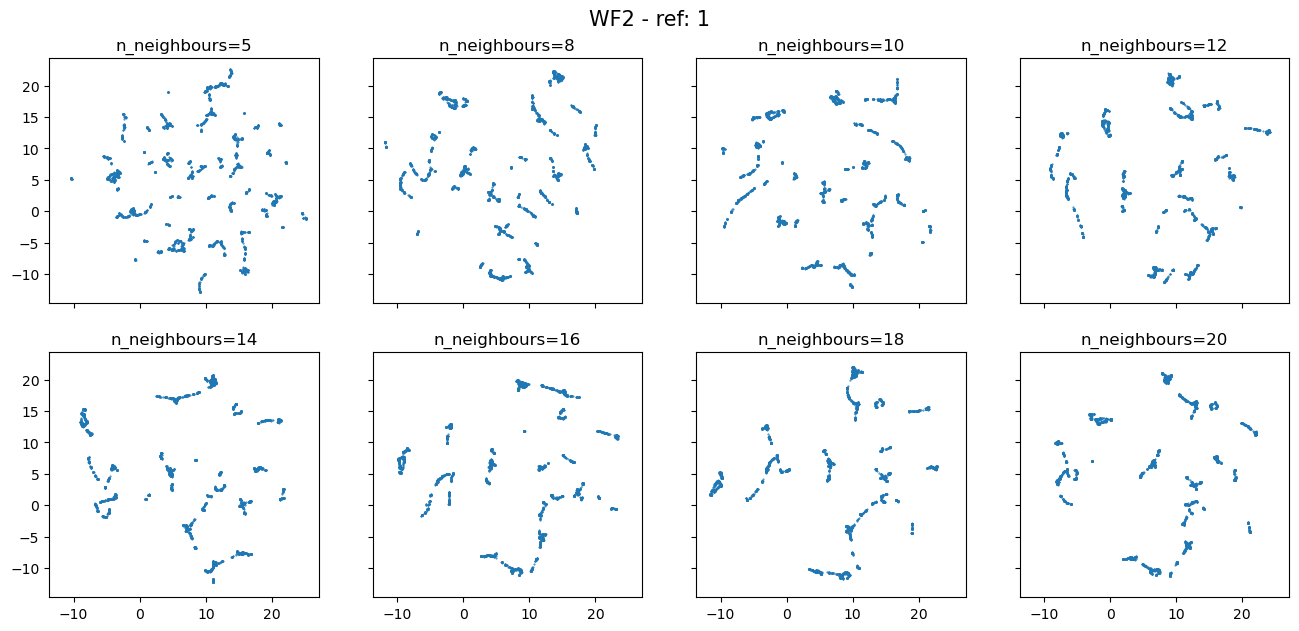

In [142]:

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 7), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.2)
fig.suptitle(f"{peptide} - ref: {ref_pep}", fontsize=15, y=0.95)


# loop through tickers and axes
for n_neigh, ax in zip([5, 8, 10, 12, 14, 16, 18, 20], axs.ravel()):
    X_embedded = umap.UMAP(
        n_neighbors=n_neigh,  # larger numbers forcus more on global properties (and increase computational effort required)
        n_components=2,  # set the number of dimensions to reduce to
        min_dist=0.0,    # must be 0.0 if points are to be clustered later with HDBSCAN
        n_jobs=1,        # use all available cores
        random_state=500
        ).fit_transform(all_pos)
    ax.set_title(f"n_neighbours={n_neigh}")
    ax.scatter(X_embedded[:,0], X_embedded[:,1], s=0.2)
plt.savefig(f"{output_dir}/explore_n_neigh_{ref_pep}.png", dpi=400, bbox_inches="tight")


UMAP(min_dist=0.0, n_jobs=1, n_neighbors=20, random_state=500, verbose=True)
Tue Jun 27 15:32:05 2023 Construct fuzzy simplicial set
Tue Jun 27 15:32:17 2023 Finding Nearest Neighbors
Tue Jun 27 15:32:19 2023 Finished Nearest Neighbor Search
Tue Jun 27 15:32:19 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue Jun 27 15:32:29 2023 Finished embedding


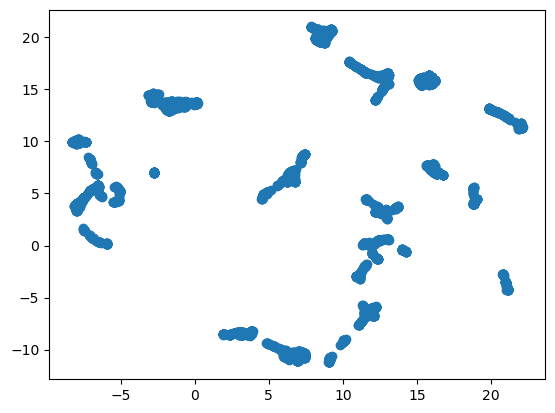

In [143]:

X_embedded = umap.UMAP(
    n_neighbors=20,  # larger numbers forcus more on global properties (and increase computational effort required)
    n_components=2,  # set the number of dimensions to reduce to
    min_dist=0.0,    # must be 0.0 if points are to be clustered later with HDBSCAN
    verbose=True,
    n_jobs=1,        # use all available cores
    random_state=500
).fit_transform(all_pos)

plt.scatter(X_embedded[:,0], X_embedded[:,1])

### Continue analysis with the chosen parameter

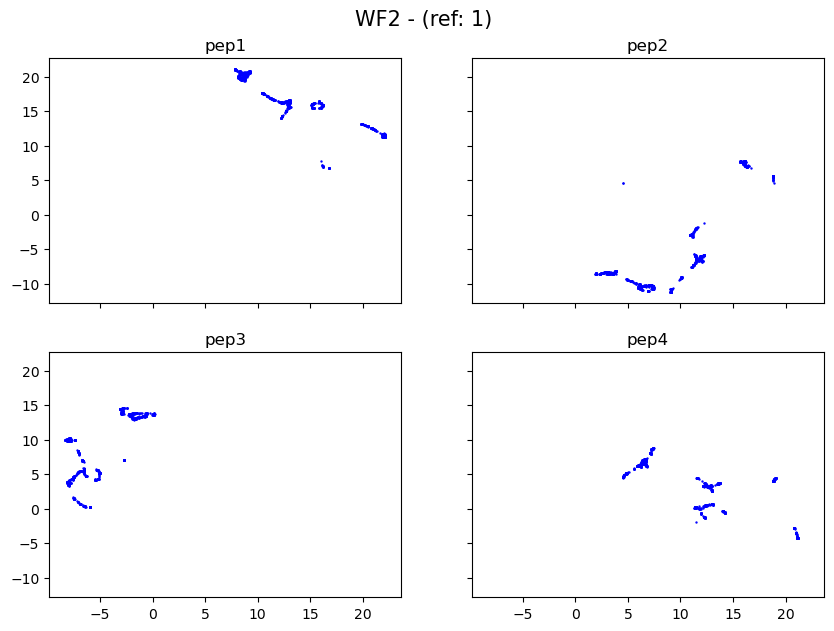

In [151]:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 7), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.2)
fig.suptitle(f"{peptide} - (ref: {ref_pep})", fontsize=15, y=0.95)


# loop through tickers and axes
for pep, ax in zip([1, 2,3, 4], axs.ravel()):
    n=n_frames
    ax.scatter(X_embedded[(pep-1)*n:pep*n-1,0], X_embedded[(pep-1)*n:pep*n-1,1], c='blue', s=0.5)
    ax.set_title(f"pep{pep}")
plt.savefig(f"{output_dir}/clusters_per_pep_ref_{ref_pep}.png", dpi=400, bbox_inches="tight")


## Cluster with HDBSCAN

Not in a cluster: 25 (0.62%)


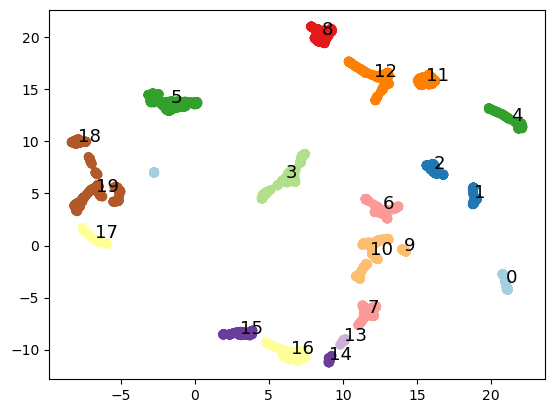

In [152]:
import hdbscan


hdb = hdbscan.HDBSCAN(
    min_cluster_size=30,              # minimum number of points for a group to be considered a cluster
    cluster_selection_epsilon=1,      # clusters closer than this distance apart will be merged
    cluster_selection_method="leaf"   # changes the way clusters are initialised. "eom" tends to lead to fewer clusters than "leaf"
)

hdb.fit(X_embedded)

y_pred = hdb.fit_predict(X_embedded)

print(f"Not in a cluster: {sum(y_pred==-1)} ({100 * sum(y_pred==-1) / y_pred.size:.2f}%)")

plt.scatter(X_embedded[:,0], X_embedded[:,1],c=y_pred, cmap='Paired')

for cluster in range(max(y_pred)+1):    
    mean = np.mean(X_embedded[y_pred==cluster], axis=0)
    plt.text(
        mean[0], mean[1],
        cluster,
        fontsize=13
    )
plt.savefig(f"{output_dir}/clusters_{peptide}_ref_{ref_pep}.png", dpi=400, bbox_inches="tight")
cluster_labels = y_pred

In [147]:
unique_cluster_labels = np.unique(cluster_labels)   
unique_cluster_labels.shape

(17,)

## First identify representative frame for each cluster

NameError: name 'all_distances' is not defined

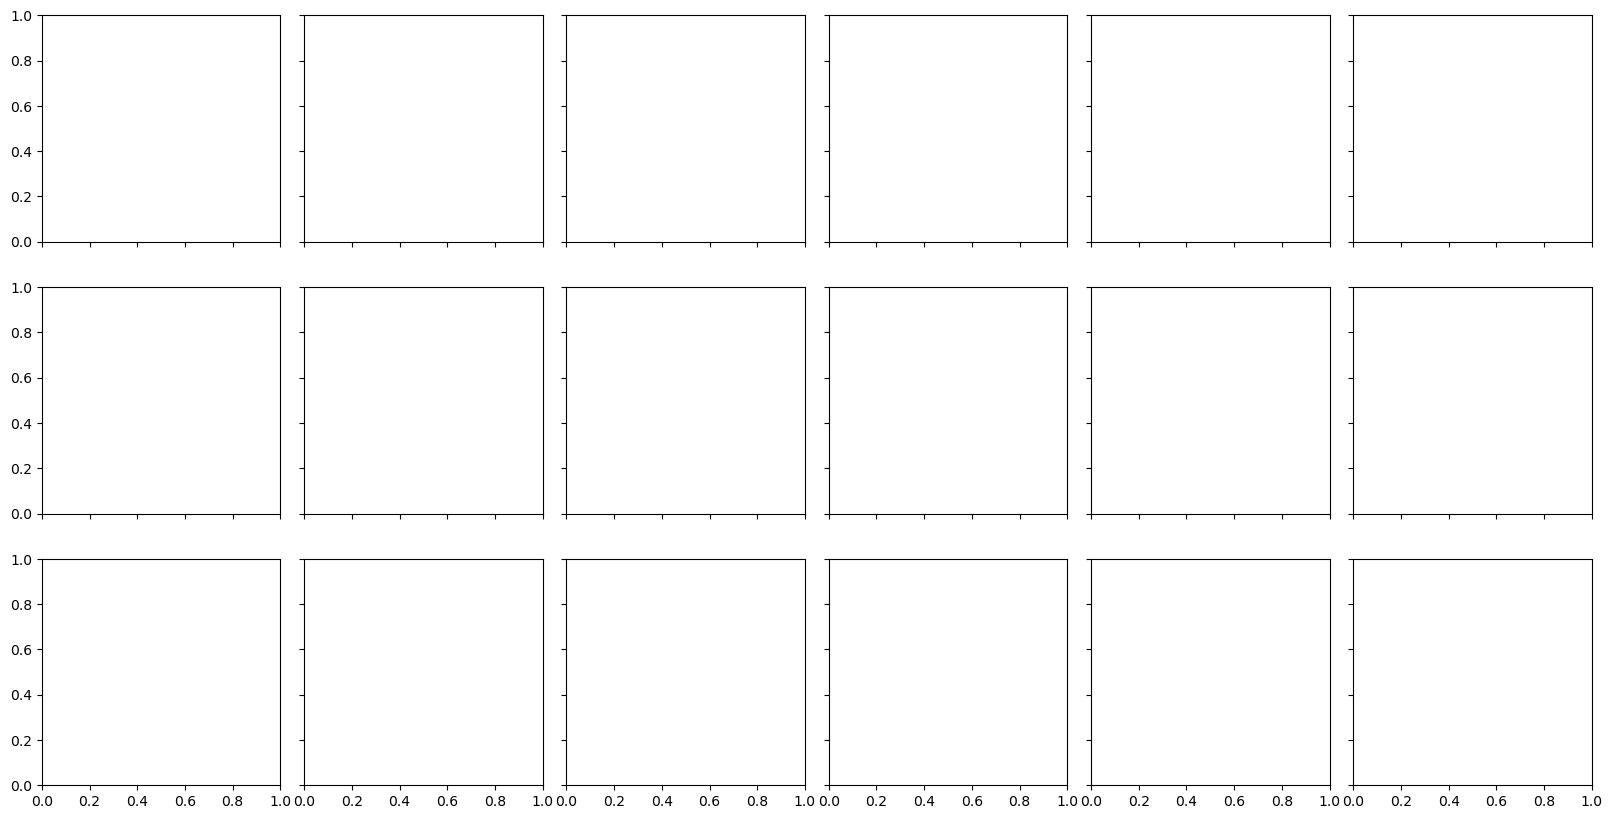

In [28]:
# get unique clusters  
unique_cluster_labels = np.unique(cluster_labels)   

fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(20, 10), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.2, wspace=0.1)


# loop through tickers and axes
for cluster, ax in zip(unique_cluster_labels, axs.ravel()):
    frames= np.where(cluster_labels==cluster)[0]
    distances_cluster = all_distances[frames]
    column_averages = np.mean(distances_cluster, axis=0)
    ax.bar(range(0,25), column_averages)
    ax.set_title(f"cluster {cluster}")

plt.savefig(f"{output_dir}/clusters_mean_{peptide}_ref_{ref_pep}.png", dpi=400, bbox_inches="tight")



## Compare structures in each cluster

In [172]:
n_frames_orig=n_frames

output_dir_rmsd =f"{output_dir}/rmsd"
Path(output_dir_rmsd).mkdir(parents=True, exist_ok=True)

def compare_struct_in_cluster_rmsd():
    n=n_frames_orig
    
    cluster_dict = {c: [] for c in cluster_labels}
    for pep, ids in pep_dict.items():

        start_id, end_id = ids
        backbone = u.select_atoms(f"name CA and resid {start_id}:{end_id}")
        cluster_labels_pep = cluster_labels[(pep-1)*n:pep*n]

        for cluster in tqdm(np.unique(cluster_labels_pep)):
            
            # frames at which cluster is found
            frames = np.where(cluster_labels_pep==cluster)[0]
            
            
            # align all and get positions
            for frame_index, ts in enumerate(u.trajectory[frames]):
            
                backbone.translate(-backbone.center_of_geometry())
                R, rmsd = rotation_matrix(backbone.positions, ref_pos)
                backbone.rotate(R)
                cluster_dict[cluster].append(rmsd)

    for cluster, rmsd_vals in cluster_dict.items():
        plt.figure()
        plt.plot(rmsd_vals)
        plt.title(f'cluster {cluster}')

        plt.savefig(f"{output_dir_rmsd}/rmsd_cluster_{cluster}.png", dpi=400, bbox_inches="tight")
        plt.close()
    return cluster_dict

In [173]:
rmsd_cluster = compare_struct_in_cluster_rmsd()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [291]:
n_frames_orig=n_frames

output_dir_rmsd =f"{output_dir}/rgyr"
Path(output_dir_rmsd).mkdir(parents=True, exist_ok=True)

def compare_struct_in_cluster_rgyr():
    n=n_frames_orig
    
    cluster_dict = {c: [] for c in cluster_labels}
    for pep, ids in pep_dict.items():

        start_id, end_id = ids
        backbone = u.select_atoms(f"name CA and resid {start_id}:{end_id}")
        cluster_labels_pep = cluster_labels[(pep-1)*n_frames:pep*n_frames]

        for cluster in tqdm(np.unique(cluster_labels_pep)):
            
            # frames at which cluster is found
            frames = np.where(cluster_labels_pep==cluster)[0]
            
            
            # align all and get positions
            for frame_index, ts in enumerate(u.trajectory[frames]):
            
                backbone.translate(-backbone.center_of_geometry())
                R, rmsd = rotation_matrix(backbone.positions, ref_pos)
                backbone.rotate(R)

                cluster_dict[cluster].append(backbone.radius_of_gyration())

    for cluster, rgyr_vals in cluster_dict.items():
        plt.figure()
        plt.plot(rgyr_vals)
        plt.title(f'Rgyr cluster {cluster}')
        plt.savefig(f"{output_dir_rmsd}/rgyr_cluster_{cluster}.png", dpi=400, bbox_inches="tight")
        plt.close()
    return cluster_dict

In [292]:
rmsd_cluster = compare_struct_in_cluster_rgyr()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

# Save Cluster data

In [65]:
import pandas as pd 

cluster_labels_pep1 = cluster_labels[:n_frames]
cluster_labels_pep2 = cluster_labels[n_frames:2*n_frames]
cluster_labels_pep3 = cluster_labels[2*n_frames:3*n_frames]
cluster_labels_pep4 = cluster_labels[3*n_frames:4*n_frames]
cluster_labels_time = pd.DataFrame([cluster_labels_pep1 , cluster_labels_pep2, cluster_labels_pep3, cluster_labels_pep4])
cluster_labels_time = cluster_labels_time.T
cluster_labels_time.columns = ["pep5", "pep6", "pep7", "pep8"]
cluster_labels_time.to_csv(f"{output_dir}/cluster_labels.csv")
cluster_labels_time


,pep5,pep6,pep7,pep8
0,20,20,10,20
1,20,20,10,20
2,20,20,10,20
3,20,20,10,20
4,20,20,10,20
...,...,...,...,...
996,5,13,9,3
997,5,13,9,3
998,5,13,1,3
999,5,13,1,3


In [66]:
frames_from_csv = pd.read_csv("frames.csv")
frames_from_csv = frames_from_csv.drop(columns=["Unnamed: 0"])
frames_from_csv

,0
0,0
1,50
2,100
3,150
4,200
...,...
996,49800
997,49850
998,49900
999,49950


In [67]:
cluster_frames_saved = frames_from_csv.join(cluster_labels_time)
cluster_frames_saved = cluster_frames_saved.rename(columns={"0":"Timeframe"})
cluster_frames_saved

,Timeframe,pep5,pep6,pep7,pep8
0,0,20,20,10,20
1,50,20,20,10,20
2,100,20,20,10,20
3,150,20,20,10,20
4,200,20,20,10,20
...,...,...,...,...,...
996,49800,5,13,9,3
997,49850,5,13,9,3
998,49900,5,13,1,3
999,49950,5,13,1,3


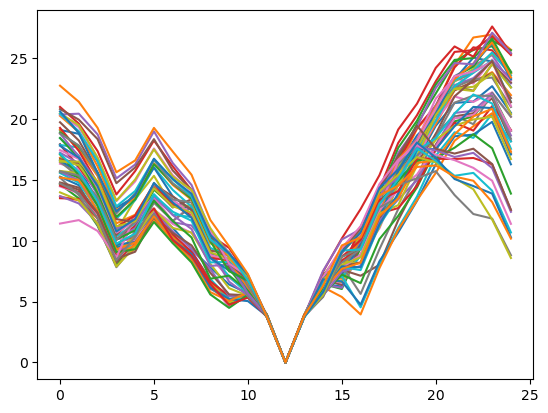

In [583]:
frames =  np.where(cluster_labels==9)[0]
positions_cluster = all_distances[frames]
# plt.scatter()
for i in  positions_cluster:
    plt.plot(i)

# Write PDBs

In [153]:
from MDAnalysis.analysis.rms import rmsd as rmsd_mdanalysis
print(output_dir)
output_dir_pdb =f"{output_dir}/pdbs"
Path(output_dir_pdb).mkdir(parents=True, exist_ok=True)



def write_pdb_per_pep(pep, frames):
    start_id, end_id = pep_dict[pep]

    backbone = u.select_atoms(f"resid {start_id}:{end_id}")

    cluster_labels_pep = cluster_labels[(pep-1)*n_frames:pep*n_frames]
    list_peptide, list_cluster, list_first_frame, list_cluster_frames, list_the_frame = [], [], [], [], []
    for cluster in tqdm(np.unique(cluster_labels_pep)):
        list_peptide.append(pep)
        
        # ref structures will be first structure in a cluster 
        first_frame_index = np.where(cluster_labels_pep==cluster)[0][0]
        
        first_frame = frames[first_frame_index]
        list_first_frame.append(first_frame)


        for frame_index in u.trajectory[[first_frame]]:
            ref_pos = backbone.unwrap()


        # frames at which cluster is found
        frames_indexes = np.where(cluster_labels_pep==cluster)[0]
        frames_cluster = frames[frames_indexes]
        list_cluster_frames.append(frames_cluster)
        list_cluster.append(cluster)


        cluster_pos = np.full((len(frames_cluster), backbone.n_atoms, 3), fill_value=np.NaN)
        
        # align all and get positions
        for frame_index, ts in enumerate(u.trajectory[frames_cluster]):

            backbone.translate(-backbone.center_of_geometry())
            R, rmsd = rotation_matrix(backbone.positions, ref_pos)
            backbone.rotate(R)
            cluster_pos[frame_index] = backbone.positions

        # find mean position
        mean = np.mean(cluster_pos, axis=0)
        
        # calculate rmsds to mean position
        rmsd = np.mean(np.sum((np.square(cluster_pos - mean)), axis=2), axis=1)
        # rmsd = rmsd_mdanalysis(cluster_pos, mean)

        # find frame at which rmsd to mean position is smallest
        rep_frame_index = np.where(rmsd==min(rmsd))[0][0]


        rep_frame = frames_cluster[rep_frame_index]
        list_the_frame.append(rep_frame)
        
        # load coordinates from representative frame
        for frame_index, ts in enumerate(u.trajectory[[rep_frame]]):
            # translate and rotate aroms
            atoms = backbone
            atoms.unwrap(inplace=True)
            atoms.translate(-backbone.center_of_mass())

            R, rmsd = rotation_matrix(backbone.positions, ref_pos)
            atoms.rotate(R)

            # write pdb
            atoms.write(f"{output_dir_pdb}/cluster_{cluster}_pep{pep}.pdb")
            print("Wrote pdb")
    return (list_peptide, list_cluster, list_first_frame, list_cluster_frames, list_the_frame)

/Users/mirunaserian/Documents/WF_synergy/umap/WF2_step50_positions


In [154]:
u, frames, n_frames =  load_traj()

list_peptide, list_cluster, list_first_frame, list_cluster_frames, list_the_frame = [], [], [], [], []
for pep in pep_dict.keys():
    list_peptide1, list_cluster1, list_first_frame1, list_cluster_frames1, list_the_frame1 = write_pdb_per_pep(pep, frames)
    list_peptide.append(list_peptide1)
    list_cluster.append(list_cluster1)
    list_first_frame.append(list_first_frame1)
    list_cluster_frames.append(list_cluster_frames1)
    list_the_frame.append(list_the_frame1)

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/mirunaserian/opt/anaconda3/envs/py39_umap/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/Users/mirunaserian/opt/anaconda3/envs/py39_umap/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/Users/mirunaserian/opt/anaconda3/envs/py39_umap/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'chainIDs' Using default value of ''
  warnings.warn("Found no information for attr: '{}'"
/Users/mirunaserian/opt/anaconda3/envs/py39_umap/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/Us

Wrote pdb
Wrote pdb
Wrote pdb
Wrote pdb
Wrote pdb


  0%|          | 0/9 [00:00<?, ?it/s]

Wrote pdb
Wrote pdb
Wrote pdb
Wrote pdb
Wrote pdb
Wrote pdb
Wrote pdb
Wrote pdb
Wrote pdb


  0%|          | 0/5 [00:00<?, ?it/s]

Wrote pdb
Wrote pdb
Wrote pdb
Wrote pdb
Wrote pdb


  0%|          | 0/6 [00:00<?, ?it/s]

Wrote pdb
Wrote pdb
Wrote pdb
Wrote pdb
Wrote pdb
Wrote pdb


In [84]:
def unpack_lists(x):
    return_list = []
    for i in x:
        for e in i:
            return_list.append(e)
    return return_list

In [103]:
structure_dataframe = pd.DataFrame([[unpack_lists(list_peptide)[k], unpack_lists(list_cluster)[k], 
                                    unpack_lists(list_first_frame)[k], unpack_lists(list_cluster_frames)[k], unpack_lists(list_the_frame)[k]]
                                    for k in range(len(unpack_lists(list_cluster)))],
                                    columns=["peptide", "cluster", "first_frame", "cluster_frames", "the_frame"])

In [104]:
structure_dataframe

,peptide,cluster,first_frame,cluster_frames,the_frame
0,1,0,1000,"[1000, 1050, 1100, 1150, 1200, 1250, 1300, 140...",9400
1,1,2,18750,"[18750, 19750, 19800, 19850, 19900, 19950, 200...",32400
2,1,4,35800,"[35800, 35850, 35900, 36000, 36200, 36250, 363...",37350
3,1,5,15200,"[15200, 16150, 16200, 38550, 38600, 39150, 392...",40900
4,1,7,13700,"[13700, 13750, 13850, 13900, 14000, 14050, 141...",15600
5,1,8,16900,"[16900, 17500, 17600, 17900, 19350, 19450, 206...",25850
6,1,20,0,"[0, 50, 100, 150, 200, 250, 300, 350, 400, 450...",550
7,2,11,11850,[11850],11850
8,2,12,2100,"[2100, 2200, 2400, 2450, 2500, 2550, 2600, 265...",6050
9,2,13,20250,"[20250, 20350, 23250, 23300, 23350, 23400, 234...",26250


In [111]:
cluster_frames_saved.set_index("Timeframe")

,pep5,pep6,pep7,pep8
Timeframe,,,,
0,20,20,10,20
50,20,20,10,20
100,20,20,10,20
150,20,20,10,20
200,20,20,10,20
...,...,...,...,...
49800,5,13,9,3
49850,5,13,9,3
49900,5,13,1,3


In [114]:
cluster_frames_saved.loc[cluster_frames_saved['pep5'] == 8]

,Timeframe,pep5,pep6,pep7,pep8
338,16900,8,14,10,16
350,17500,8,14,10,16
352,17600,8,14,10,16
358,17900,8,14,10,16
387,19350,8,14,10,16
...,...,...,...,...,...
761,38050,8,17,9,11
762,38100,8,18,1,11
774,38700,8,15,9,11
780,39000,8,15,9,11
